In [25]:
#重回帰（Lasso）→係数0削除→主成分分析→Kmean→Cluster特徴発見→重回帰LassoでClusterごとの係数を分析

### ----------------- 機械学習 ------------------ ###
# PySparkについて：　数GBのデータをリアルタイムに解析したい場合以外はPandasの方が断然お得

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import scikit-learn

# path = 'C:\\Users\\fobay\\Jupyter\\DataAnalysis\\YFData'
# path = 'C:/Users/fobay/Jupyter/DataAnalysis/YFData' #For Jupyter
path = 'C:/Users/fumi9/Desktop/DFS/Colab Notebooks/Kaggle/HousePrice'
# path = '/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/' # For Colab
os.chdir(path)

Dataset = pd.read_csv(os.getcwd() + "/train.csv", encoding='CP932')

# Dataset.tail(5)
print(Dataset.shape)

(1460, 81)


In [ ]:
#欠損データの補間
#①定性的な指標を定量に直す（例：１週間ー＞７、２週間ー＞１４）
#②OneHotEncoding（get_dummiesでもOK）する項目を明記
    #Dataset = pd.get_dummies(Dataset, columns=["性別"])
#③次元ごとの寄与率を確認（一般的に1以上の固有値の項目が元のデータと関係が深い）
#カテゴリカルデータの分解と統合（今は使用しない）

In [27]:
Dataset.isnull().sum()[Dataset.isnull().sum()>0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [28]:
# 欠損を含むカラムのデータ型を確認
na_col_list = Dataset.isnull().sum()[Dataset.isnull().sum()>0].index.tolist() # 欠損を含むカラムをリスト化
Dataset[na_col_list].dtypes.sort_values() #データ型

LotFrontage     float64
MasVnrArea      float64
GarageYrBlt     float64
PoolQC           object
GarageCond       object
GarageQual       object
GarageFinish     object
GarageType       object
FireplaceQu      object
Electrical       object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
BsmtQual         object
MasVnrType       object
Alley            object
Fence            object
MiscFeature      object
dtype: object

In [29]:
# データ型に応じて欠損値を補完する
# floatの場合は0
# objectの場合は'NA'
na_float_cols = Dataset[na_col_list].dtypes[Dataset[na_col_list].dtypes=='float64'].index.tolist() #float64
na_obj_cols = Dataset[na_col_list].dtypes[Dataset[na_col_list].dtypes=='object'].index.tolist() #object
# float64型で欠損している場合は0を代入
for na_float_col in na_float_cols:
    Dataset.loc[Dataset[na_float_col].isnull(),na_float_col] = 0.0
# object型で欠損している場合は'NA'を代入
for na_obj_col in na_obj_cols:
    Dataset.loc[Dataset[na_obj_col].isnull(),na_obj_col] = 'NA'

In [31]:
# マージデータの欠損状況
Dataset.isnull().sum()[Dataset.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

In [35]:
# カテゴリカル変数の特徴量をリスト化
cat_cols = Dataset.dtypes[Dataset.dtypes=='object'].index.tolist()
# 数値変数の特徴量をリスト化
num_cols = Dataset.dtypes[Dataset.dtypes!='object'].index.tolist()

# カテゴリカル変数をダミー化
alldata_cat = pd.get_dummies(Dataset[cat_cols])

# データ統合
all_data = pd.concat([Dataset[num_cols],alldata_cat],axis=1)

C:\Users\fumi9\Desktop\DFS\WebAnalysis\.WebAnalysisEnv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

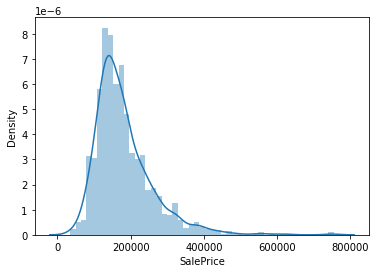

In [37]:
sns.distplot(all_data['SalePrice'])

C:\Users\fumi9\Desktop\DFS\WebAnalysis\.WebAnalysisEnv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

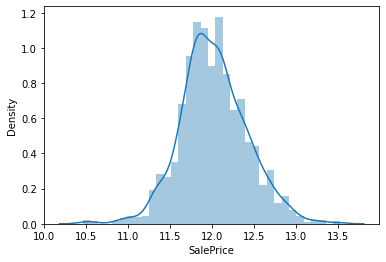

In [39]:
sns.distplot(np.log(all_data['SalePrice']))

In [45]:
all_data_ready = all_data.drop("Id", axis=1)

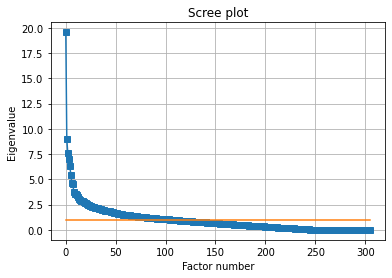

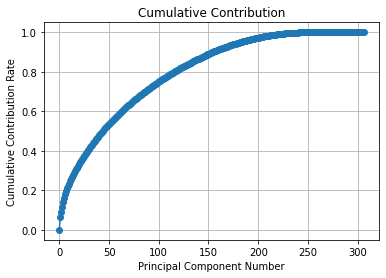

             固有値       寄与率     累積寄与率
PC1    19.553510  0.063857  0.063857
PC2     8.974791  0.029309  0.093166
PC3     7.570898  0.024725  0.117890
PC4     7.032564  0.022966  0.140857
PC5     6.310722  0.020609  0.161466
...          ...       ...       ...
PC103   1.032556  0.003372  0.761039
PC104   1.031223  0.003368  0.764406
PC105   1.019207  0.003328  0.767735
PC106   1.009547  0.003297  0.771032
PC107   0.997164  0.003256  0.774288

[107 rows x 3 columns]

必要な成分数:107 (固有値1以上の成分)


In [90]:
#スクリ―プロット
Target = all_data_ready

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # インスタンスを生成･定義
sc.fit(Target)            # データ変換の計算式を生成
z = sc.transform(Target)  # 実際にデータを変換
# print("標準化得点：\n", z)
# print(" ")
# print("行列の形状：", z.shape)

# スクリ―プロット（主成分分析の固有値を高い順にプロットー＞一般に１以上が元データとの関連性が深い）
from sklearn.decomposition import PCA
pca = PCA() # インスタンスを生成･定義
pca.fit(z)  # 標準化得点データにもとづいてモデルを生成
ev = pca.explained_variance_# 固有値を取得

ev_df = pd.DataFrame(ev, # 行名･列名を付与してデータフレームに変換
             index=["PC{}".format(x + 1) for x in range(len(Target.columns))], 
             columns=["固有値"])

# 基準線(固有値1)をひくためのダミーデータ
ev_1 = np.ones(z.shape[1])

# 変数を指定
plt.title("Scree plot")
plt.plot(ev, 's-')   # 主成分分析による固有値
plt.plot(ev_1, '-') # ダミーデータ

# 軸名を指定
plt.xlabel("Factor number")
plt.ylabel("Eigenvalue")

plt.grid()
plt.show()

# 寄与率の取得
evr = pca.explained_variance_ratio_

# 行名･列名を付与してデータフレームに変換
evr_df = pd.DataFrame(evr, 
             index=["PC{}".format(x + 1) for x in range(len(Target.columns))], 
             columns=["寄与率"])

# 起点0と寄与率の累積値をプロット
plt.plot([0] + list(np.cumsum(evr)), "-o")

cum_evr_df = pd.DataFrame(list(np.cumsum(evr)), 
             index=["PC{}".format(x + 1) for x in range(len(Target.columns))], 
             columns=["累積寄与率"])

plt.title("Cumulative Contribution")
plt.xlabel("Principal Component Number")
plt.ylabel("Cumulative Contribution Rate")

plt.grid()
plt.show()

# print(pd.concat([ev_df, evr_df, cum_evr_df], axis=1).head(int(cum_evr_df[cum_evr_df > 0.5].isnull().sum() + 1)))
print(pd.concat([ev_df, evr_df, cum_evr_df], axis=1).head(int(ev_df[ev_df < 1].isnull().sum() + 1)))
print()

# print("必要な因子の数:" + str(int(cum_evr_df[cum_evr_df > 0.5].isnull().sum() + 1)) + " (累積寄与率5x%になる因数)")
print("必要な成分数:" + str(int(ev_df[ev_df < 1].isnull().sum() + 1)) + " (固有値1以上の成分)")

C:\Users\fumi9\AppData\Local\Temp\ipykernel_4816\1678270574.py:36: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


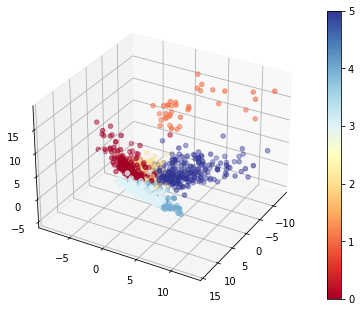

<Figure size 1152x864 with 0 Axes>

                       cluster0:227  cluster1:37  cluster2:406  cluster3:386  \
MSSubClass                56.233480    60.945946     45.985222     46.943005   
LotFrontage               47.986784    54.891892     57.943350     69.463731   
LotArea                16289.312775  9295.756757   9406.091133  11585.963731   
OverallQual                6.273128     4.297297      5.184729      7.471503   
OverallCond                5.850220     5.000000      5.815271      5.067358   
...                             ...          ...           ...           ...   
SaleCondition_Alloca       0.017621     0.081081      0.002463      0.002591   
SaleCondition_Family       0.017621     0.000000      0.019704      0.005181   
SaleCondition_Normal       0.876652     0.864865      0.886700      0.722798   
SaleCondition_Partial      0.004405     0.000000      0.004926      0.243523   
k_value                    0.000000     1.000000      2.000000      3.000000   

                       cluster4:126  cl

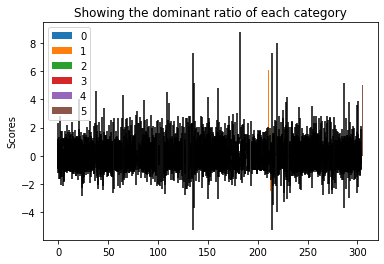

<Figure size 288x216 with 0 Axes>

In [92]:
# kMeanクラスタリング
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

#モデルの作成 
cluster_num = 6
model = KMeans(n_clusters=cluster_num)# random_state=1

#全主成分を使ってKmean
df = Target
df_scale = scale(df)

#データを正規化し、fit関数により訓練を実施
model = model.fit(df_scale)

df_model = pd.DataFrame(model.labels_)
df["k_value"] = df_model

# 3D graph描画用次元圧縮
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
arr_pca = pca.fit_transform(df_scale)
arr_pca

# 可視化 3次元
df_pca = pd.DataFrame(arr_pca,columns = ["pca_1","pca_2", "pca_3"])
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
color_value = df["k_value"]
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 30)  
cm = plt.cm.get_cmap('RdYlBu')
mappable = ax.scatter(df_pca["pca_1"].to_numpy(), df_pca["pca_2"].to_numpy(), df_pca["pca_3"].to_numpy(), c=color_value, cmap=cm)
fig.colorbar(mappable, ax=ax)
plt.figure(figsize=(16,12))
plt.show()

#Cluster内の要素の平均と標準偏差
minfo = pd.DataFrame()
for i in range(cluster_num):
    minfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df[df['k_value'] == i].mean()
sinfo = pd.DataFrame()
for i in range(cluster_num):
    sinfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df[df['k_value'] == i].std()

print(minfo)
print(sinfo)
print(df)

import matplotlib.pyplot as plt
labels = range(len(df.columns)) #range(340) #df.columns #['C1', 'C2', 'C3', 'C4', 'C5']
width = 0.35       # the width of the bars: can also be len(x) sequence

df_scaleDF = pd.DataFrame(df_scale.T, df.columns[0:len(df.columns)]).T
df_scaleDF["k_value"] = df_model

minfo_scale = pd.DataFrame()
for i in range(cluster_num):
    minfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df_scaleDF[df_scaleDF['k_value'] == i].mean()
sinfo_scale = pd.DataFrame()
for i in range(cluster_num):
    sinfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df_scaleDF[df_scaleDF['k_value'] == i].std()

# print(minfo_scale)
# print(sinfo_scale)

fig, ax = plt.subplots()
# for i in range(cluster_num):
#   means = minfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))]
#   std = sinfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))]
#   ax.bar(labels, means, width, yerr=std, label=i)
for i in range(cluster_num):
  means = minfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))][0:len(df.columns)]
  std = sinfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))][0:len(df.columns)]
  ax.bar(labels, means, width, yerr=std, label=i)
ax.set_ylabel('Scores')
ax.set_title('Showing the dominant ratio of each category')
ax.legend()

plt.figure(figsize=(4,3))
plt.show()

In [121]:
len(coeff_df[coeff_df["Coefficient Estimate"]!=0])

269

In [122]:
### ----------------- 重回帰分析 ------------------ ###
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

df = Target

# dum_dataset = short_dataset.copy()
# dum_dataset[Stock] = dum_dataset[Stock].shift(-1) # 1(-1)日後の株価を、今日までの他のストックの価格を使ってを予測
# dum_dataset.dropna(inplace=True)

lreg = Lasso()#LinearRegression()
x_multi = df.drop("SalePrice", axis=1)
x_multi.shape
y_target = df["SalePrice"]
lreg.fit(x_multi, y_target)
# print(lreg.intercept_)
# print(len(lreg.coef_))

#Linear regression
coeff_df = pd.DataFrame(df.columns)
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(lreg.coef_)
coeff_df.to_csv('C:/Users/fumi9/Desktop/DFS/Colab Notebooks/Kaggle/HousePrice/coeff.csv')


df[coeff_df[coeff_df["Coefficient Estimate"]!=0]]

# path = 'C:/Users/fumi9/Desktop/DFS/Colab Notebooks/Kaggle/HousePrice'
# Dataset = pd.read_csv(os.getcwd() + "/train.csv", encoding='CP932')

# #Training
# X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x_multi, y_target)
# print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape )
# lreg = Lasso()#LinearRegression()
# lreg.fit(X_train, Y_train)

# pred_train = lreg.predict(X_train)
# pred_test = lreg.predict(X_test)
# print(np.mean((Y_train - pred_train) ** 2))
# print(np.mean((Y_test - pred_test) ** 2))

C:\Users\fumi9\Desktop\DFS\WebAnalysis\.WebAnalysisEnv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e+11, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


In [131]:
df[coeff_df[coeff_df["Coefficient Estimate"]!=0]["Features"]].columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'k_value'],
      dtype='object', length=269)

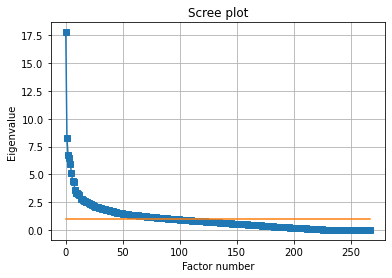

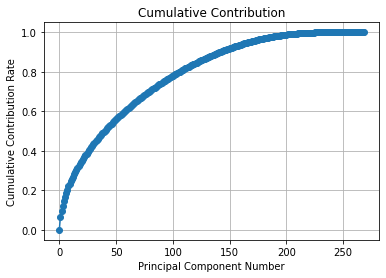

            固有値       寄与率     累積寄与率
PC1   17.781871  0.066305  0.066305
PC2    8.300888  0.030952  0.097257
PC3    6.719523  0.025056  0.122313
PC4    6.445487  0.024034  0.146347
PC5    5.917363  0.022065  0.168411
...         ...       ...       ...
PC90   1.036677  0.003866  0.743594
PC91   1.023399  0.003816  0.747410
PC92   1.013704  0.003780  0.751190
PC93   1.003997  0.003744  0.754934
PC94   0.989451  0.003689  0.758624

[94 rows x 3 columns]

必要な成分数:94 (固有値1以上の成分)


In [132]:
#スクリ―プロット2
Target = df[coeff_df[coeff_df["Coefficient Estimate"]!=0]["Features"]].drop("k_value", axis=1)

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # インスタンスを生成･定義
sc.fit(Target)            # データ変換の計算式を生成
z = sc.transform(Target)  # 実際にデータを変換
# print("標準化得点：\n", z)
# print(" ")
# print("行列の形状：", z.shape)

# スクリ―プロット（主成分分析の固有値を高い順にプロットー＞一般に１以上が元データとの関連性が深い）
from sklearn.decomposition import PCA
pca = PCA() # インスタンスを生成･定義
pca.fit(z)  # 標準化得点データにもとづいてモデルを生成
ev = pca.explained_variance_# 固有値を取得

ev_df = pd.DataFrame(ev, # 行名･列名を付与してデータフレームに変換
             index=["PC{}".format(x + 1) for x in range(len(Target.columns))], 
             columns=["固有値"])

# 基準線(固有値1)をひくためのダミーデータ
ev_1 = np.ones(z.shape[1])

# 変数を指定
plt.title("Scree plot")
plt.plot(ev, 's-')   # 主成分分析による固有値
plt.plot(ev_1, '-') # ダミーデータ

# 軸名を指定
plt.xlabel("Factor number")
plt.ylabel("Eigenvalue")

plt.grid()
plt.show()

# 寄与率の取得
evr = pca.explained_variance_ratio_

# 行名･列名を付与してデータフレームに変換
evr_df = pd.DataFrame(evr, 
             index=["PC{}".format(x + 1) for x in range(len(Target.columns))], 
             columns=["寄与率"])

# 起点0と寄与率の累積値をプロット
plt.plot([0] + list(np.cumsum(evr)), "-o")

cum_evr_df = pd.DataFrame(list(np.cumsum(evr)), 
             index=["PC{}".format(x + 1) for x in range(len(Target.columns))], 
             columns=["累積寄与率"])

plt.title("Cumulative Contribution")
plt.xlabel("Principal Component Number")
plt.ylabel("Cumulative Contribution Rate")

plt.grid()
plt.show()

# print(pd.concat([ev_df, evr_df, cum_evr_df], axis=1).head(int(cum_evr_df[cum_evr_df > 0.5].isnull().sum() + 1)))
print(pd.concat([ev_df, evr_df, cum_evr_df], axis=1).head(int(ev_df[ev_df < 1].isnull().sum() + 1)))
print()

# print("必要な因子の数:" + str(int(cum_evr_df[cum_evr_df > 0.5].isnull().sum() + 1)) + " (累積寄与率5x%になる因数)")
print("必要な成分数:" + str(int(ev_df[ev_df < 1].isnull().sum() + 1)) + " (固有値1以上の成分)")

C:\Users\fumi9\AppData\Local\Temp\ipykernel_4816\2512906362.py:35: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


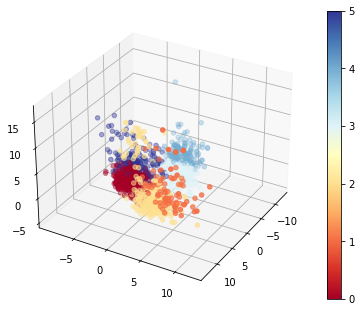

<Figure size 1152x864 with 0 Axes>

                       cluster0:376  cluster1:81  cluster2:273  cluster3:374  \
MSSubClass                47.287234    71.790123     57.985348     68.061497   
LotFrontage               57.393617    55.185185     57.252747     52.949198   
LotArea                 9406.502660  7469.679012   9008.641026   8787.489305   
OverallQual                5.234043     4.604938      5.263736      6.871658   
OverallCond                5.909574     5.530864      5.959707      5.053476   
...                             ...          ...           ...           ...   
SaleCondition_Alloca       0.002660     0.012346      0.018315      0.002674   
SaleCondition_Family       0.021277     0.000000      0.018315      0.002674   
SaleCondition_Normal       0.882979     0.753086      0.882784      0.802139   
SaleCondition_Partial      0.002660     0.024691      0.000000      0.157754   
k_value                    0.000000     1.000000      2.000000      3.000000   

                       cluster4:160  cl

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [135]:
# kMeanクラスタリング2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

#モデルの作成 
cluster_num = 6
model = KMeans(n_clusters=cluster_num)# random_state=1

#全主成分を使ってKmean
df = Target
df_scale = scale(df)

#データを正規化し、fit関数により訓練を実施
model = model.fit(df_scale)

df_model = pd.DataFrame(model.labels_)
df["k_value"] = df_model

# 3D graph描画用次元圧縮
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
arr_pca = pca.fit_transform(df_scale)
arr_pca

# 可視化 3次元
df_pca = pd.DataFrame(arr_pca,columns = ["pca_1","pca_2", "pca_3"])
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
color_value = df["k_value"]
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 30)  
cm = plt.cm.get_cmap('RdYlBu')
mappable = ax.scatter(df_pca["pca_1"].to_numpy(), df_pca["pca_2"].to_numpy(), df_pca["pca_3"].to_numpy(), c=color_value, cmap=cm)
fig.colorbar(mappable, ax=ax)
plt.figure(figsize=(16,12))
plt.show()

#Cluster内の要素の平均と標準偏差
minfo = pd.DataFrame()
for i in range(cluster_num):
    minfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df[df['k_value'] == i].mean()
sinfo = pd.DataFrame()
for i in range(cluster_num):
    sinfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df[df['k_value'] == i].std()

print(minfo)
print(sinfo)
print(df)

import matplotlib.pyplot as plt
labels = range(len(df.columns)) #range(340) #df.columns #['C1', 'C2', 'C3', 'C4', 'C5']
width = 0.35       # the width of the bars: can also be len(x) sequence

df_scaleDF = pd.DataFrame(df_scale.T, df.columns[0:len(df.columns)]-1).T
df_scaleDF["k_value"] = df_model

minfo_scale = pd.DataFrame()
for i in range(cluster_num):
    minfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df_scaleDF[df_scaleDF['k_value'] == i].mean()
sinfo_scale = pd.DataFrame()
for i in range(cluster_num):
    sinfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))] = df_scaleDF[df_scaleDF['k_value'] == i].std()

# print(minfo_scale)
# print(sinfo_scale)

fig, ax = plt.subplots()
# for i in range(cluster_num):
#   means = minfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))]
#   std = sinfo['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))]
#   ax.bar(labels, means, width, yerr=std, label=i)
for i in range(cluster_num):
  means = minfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))][0:len(df.columns)]
  std = sinfo_scale['cluster' + str(i) + ':' + str(len(df[df["k_value"]==i]))][0:len(df.columns)]
  ax.bar(labels, means, width, yerr=std, label=i)
ax.set_ylabel('Scores')
ax.set_title('Showing the dominant ratio of each category')
ax.legend()

plt.figure(figsize=(4,3))
plt.show()

In [136]:
### ----------------- 重回帰分析2 ------------------ ###
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

df = Target

# dum_dataset = short_dataset.copy()
# dum_dataset[Stock] = dum_dataset[Stock].shift(-1) # 1(-1)日後の株価を、今日までの他のストックの価格を使ってを予測
# dum_dataset.dropna(inplace=True)

lreg = Lasso()#LinearRegression()
x_multi = df.drop("SalePrice", axis=1)
x_multi.shape
y_target = df["SalePrice"]
lreg.fit(x_multi, y_target)
# print(lreg.intercept_)
# print(len(lreg.coef_))

#Linear regression
coeff_df = pd.DataFrame(df.columns)
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(lreg.coef_)
coeff_df.to_csv('C:/Users/fumi9/Desktop/DFS/Colab Notebooks/Kaggle/HousePrice/coeff.csv')


# df[coeff_df[coeff_df["Coefficient Estimate"]!=0]]

# path = 'C:/Users/fumi9/Desktop/DFS/Colab Notebooks/Kaggle/HousePrice'
# Dataset = pd.read_csv(os.getcwd() + "/train.csv", encoding='CP932')
    
# #Training
# X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x_multi, y_target)
# print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape )
# lreg = Lasso()#LinearRegression()
# lreg.fit(X_train, Y_train)

# pred_train = lreg.predict(X_train)
# pred_test = lreg.predict(X_test)
# print(np.mean((Y_train - pred_train) ** 2))
# print(np.mean((Y_test - pred_test) ** 2))

C:\Users\fumi9\Desktop\DFS\WebAnalysis\.WebAnalysisEnv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.444e+11, tolerance: 9.208e+08
  model = cd_fast.enet_coordinate_descent(


In [19]:
!pip install factor-analyzer

'pip' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [21]:
# 因数分析
from factor_analyzer import FactorAnalyzer
n = 3 #スクリ―プロットより決定

fa = FactorAnalyzer(n_factors=n, rotation='promax', impute='drop') #プロマックス回転
fa.fit(z)
# print(fa.loadings_)

df_result = pd.DataFrame(fa.loadings_, 
           index = Target.columns,
            columns=["因子{}".format(x + 1) for x in range(n)])

# 因子に高い負荷量を持つ項目は最低３つないと因子としての構造が安定しないことが知られている
# 各因子ごとのDataframeに分けてsortした後にSortedResultにappendしている
SortedResult = pd.DataFrame(columns=["因子{}".format(x + 1) for x in range(n)])
for x in range(n):
  SortedResult = SortedResult.append(df_result[pd.DataFrame(df_result.idxmax(axis=1))[0] == "因子{}".format(x+1)].sort_values(by="因子{}".format(x+1), ascending=False))
SortedResult

import seaborn as sns
cm = sns.light_palette("red", as_cmap=True)
SortedResult.style.background_gradient(cmap=cm)

# df_result_sort.to_csv()

,因子1,因子2,因子3
車やバイクなど乗り物の運転がうまくなりたい,0.878141,-0.051996,-0.058964
車やバイクを運転するときは周りよりスピードを出したい,0.815633,0.069686,-0.202206
ガレージの中で、自分の乗り物(車、モーターバイク、自転車、etc）を磨いたり、必要なメンテナンスをするのは、楽しみの一つだ,0.814744,0.204988,-0.042397
移動手段や乗り物は異性や他人の目を気にして選ぶ,0.763373,-0.305086,-0.036795
車やバイクなどの移動手段や乗り物は趣味として所有したい,0.676633,0.122999,-0.128863
移動手段や乗り物も自己表現の道具だと思う,0.580929,0.223345,0.029502
移動では風や自然を感じたい,0.559844,-0.051774,0.065813
オフロードなど、色んな地形や状況に適用できる乗り物が良い,0.542063,0.068872,0.200250
家族や友人みんなで乗れる乗り物で移動したい,0.467313,-0.029583,0.152593
移動中は一人の時間を楽しみたい,0.316006,-0.105769,0.007038


In [22]:
#--因子負荷量0.5以上に着目して人が命名する--
#因子１：うまくなりたい・目を引く・趣味・自己表現
#因子２：運転を楽しみたい
#因子３：安い・必要最低限・乗りやすい・便利

# FactorNames = [ #Over €70,000
#     "因子１：新規探索系・追及志向",
#     "因子２：消費旺盛・運動自信・楽観的",
#     "因子３：環境志向・仲間意識",
#     "因子４：現状満足・独自路線",
#     "因子５：興味消費・孤独志向",
#     "因子６：アウトドア・コスパ"
# ]
# FactorNames = [ #Over €100,000
#     "因子１：仕事より家庭・遊びはストレス解消・好奇心旺盛・自己成長",
#     "因子２：消費旺盛・楽観的・一人好き・勝ちたい",
#     "因子３：運動自身・スリル遊び・現状満足・",
#     "因子４：周囲協調型・お得な買い物・助け合い"
# ]

FactorNames = [ #移動スタイル
    "因子１：うまくなりたい・目を引く・趣味・自己表現",
    "因子２：運転を楽しみたい",
    "因子３：安い・必要最低限・乗りやすい・便利",           
]

#因数得点で階層型分類せよ!!!: https://webtopi.biz/archives/984
result_data=pd.concat([Dataset,pd.DataFrame(fa.transform(z), columns=FactorNames)],axis=1)

# result_data.head()

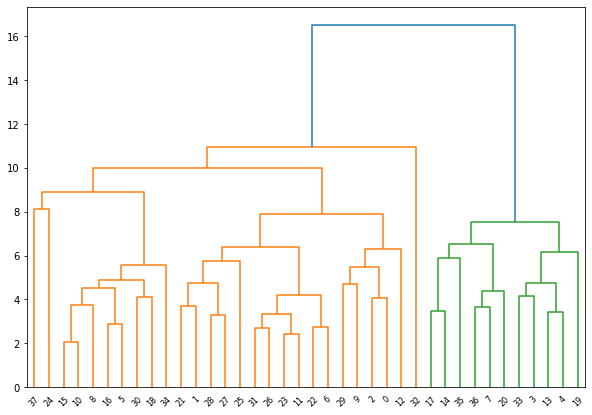

In [23]:
## こっち！階層型クラスタリング!Kmeanは使わない!
import numpy as np
from sklearn.preprocessing import scale

z = scale(Target)
X = z

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

linked = linkage(X, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

#各クラスター100サンプル以上が目安

C:\Users\fumi9\AppData\Local\Temp\ipykernel_4816\4054469114.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


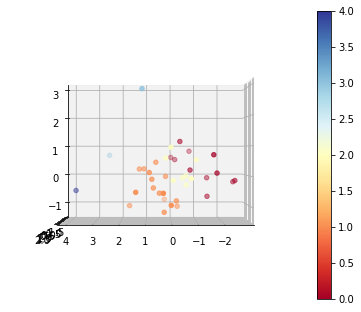

<Figure size 1152x864 with 0 Axes>

C:\Users\fumi9\Desktop\DFS\WebAnalysis\.WebAnalysisEnv\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\fumi9\Desktop\DFS\WebAnalysis\.WebAnalysisEnv\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


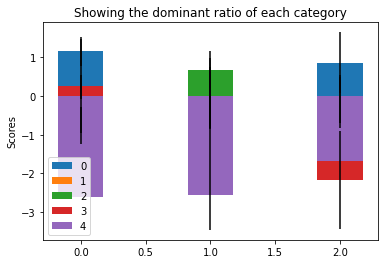

<Figure size 288x216 with 0 Axes>

In [24]:
#分類 分類は因数得点から行う
from sklearn.preprocessing import scale
Target = result_data.filter(items=FactorNames, axis='columns') #因数得点をscaleする
z = scale(Target)
Cluster_num = 5 # クラスター数は上記の階層型クラスタリング図で決める
F = fcluster(linked, t = Cluster_num, criterion = 'maxclust')

df = Target.copy()
df_scale = z
df["f_value"] = F-1 # fclusterは1以上の値なのでkmeanの0以上に変換

# 3D graph描画用次元圧縮
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
arr_pca = pca.fit_transform(df_scale)
arr_pca

# 可視化 3次元
df_pca = pd.DataFrame(arr_pca,columns = ["pca_1","pca_2", "pca_3"])
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
color_value = df["f_value"]
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(0, 90)  
cm = plt.cm.get_cmap('RdYlBu')
mappable = ax.scatter(df_pca["pca_1"].to_numpy(), df_pca["pca_2"].to_numpy(), df_pca["pca_3"].to_numpy(), c=color_value, cmap=cm)
fig.colorbar(mappable, ax=ax)
plt.figure(figsize=(16,12))
plt.show()


minfo = pd.DataFrame()
for i in range(Cluster_num):
    minfo['cluster' + str(i) + ':' + str(len(df[df["f_value"]==i]))] = df[df['f_value'] == i].mean()
sinfo = pd.DataFrame()
for i in range(Cluster_num):
    sinfo['cluster' + str(i) + ':' + str(len(df[df["f_value"]==i]))] = df[df['f_value'] == i].std()

# print(minfo)
# print(sinfo)
# print(df)

import matplotlib.pyplot as plt
labels = range(len(df.columns)-1) #range(340) #df.columns #['C1', 'C2', 'C3', 'C4', 'C5']
width = 0.35       # the width of the bars: can also be len(x) sequence

df_scaleDF = pd.DataFrame(df_scale.T, df.columns[0:len(df.columns)-1]).T
df_scaleDF["f_value"] = df["f_value"]

minfo_scale = pd.DataFrame()
for i in range(Cluster_num):
    minfo_scale['cluster' + str(i) + ':' + str(len(df[df["f_value"]==i]))] = df_scaleDF[df_scaleDF['f_value'] == i].mean()
sinfo_scale = pd.DataFrame()
for i in range(Cluster_num):
    sinfo_scale['cluster' + str(i) + ':' + str(len(df[df["f_value"]==i]))] = df_scaleDF[df_scaleDF['f_value'] == i].std()

# print(minfo_scale)
# print(sinfo_scale)

# クラスターごとにどんな因子で構成されているかを見たい！！（逆に変更しないと）
fig, ax = plt.subplots()
for i in range(Cluster_num):
  means = minfo_scale['cluster' + str(i) + ':' + str(len(df[df["f_value"]==i]))]
  std = sinfo_scale['cluster' + str(i) + ':' + str(len(df[df["f_value"]==i]))]
  ax.bar(labels, means.drop("f_value"), width, yerr=std.drop("f_value"), label=i)
ax.set_ylabel('Scores')
ax.set_title('Showing the dominant ratio of each category')
ax.legend()

plt.figure(figsize=(4,3))
plt.show()

In [ ]:
#csvファイル出力はなんか出力が変になるから.to_csv()で結果をコピペした方がいい！！
result_data["f_value"] = F-1
# df_pca["f_value"] = df["f_value"]
# df.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/df.csv')
# df_pca.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/Df_pcaWithK_value.csv')
# minfo.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/minfo.csv')
# sinfo.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/sinfo.csv')
# df.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/df.csv')
# minfo_scale.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/minfo_scale.csv')
# sinfo_scale.to_csv('/content/drive/My Drive/Colab Notebooks/DataAnalysisForFrenchAnalysis/YFData/FrenchData/sinfo_scale.csv')

In [ ]:
minfoWoF_value = minfo.drop("f_value")
minfoForRadar = (minfoWoF_value - minfoWoF_value.values.min()) / (minfoWoF_value.values.max() - minfoWoF_value.values.min())

import plotly.graph_objects as go
categories = FactorNames
fig = go.Figure()

for i in range(Cluster_num):
  fig.add_trace(go.Scatterpolar(
        r=minfoForRadar.iloc[:,i],
        theta=categories,
        fill='toself',
        name=minfoForRadar.columns[i]
  ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

In [ ]:
minfoForRadar.to_csv()

In [ ]:
#分類終了
# file ClusterAnalysis.xlsx参照
result_data.to_csv()

In [ ]:
#カテゴリカルデータの分解と統合（今は使用しない）
Dataset = pd.get_dummies(Dataset, columns=["性別"])
Dataset = pd.get_dummies(Dataset, columns=["居住地"])
Dataset = pd.get_dummies(Dataset, columns=["あなたが1番大事する価値観（行動指針）"])
Dataset = pd.get_dummies(Dataset, columns=["自動車の運転有無"])
Dataset = pd.get_dummies(Dataset, columns=["職業"])
Dataset = pd.get_dummies(Dataset, columns=["民族"])
Dataset = pd.get_dummies(Dataset, columns=["現在の居住地"])
Dataset = pd.get_dummies(Dataset, columns=["出身地（故郷）"])
Dataset = pd.get_dummies(Dataset, columns=["結婚有無"])
Dataset = pd.get_dummies(Dataset, columns=["家族構成"])

# sklearn cheat sheet: http://neuro-educator.com/ml4/
# Dataset.columns

In [ ]:
#これはいらないかも（上でやったのと一緒）

# データの標準化
from sklearn.preprocessing import scale
z = scale(Target.T)

# 次元分解（圧縮）
from sklearn.decomposition import PCA
pcamodel = PCA() # (n_components=3)
pcamodel.fit(z)

# 主成分分析詳細分析: https://santakalog.com/2021/02/13/python-pca/
pca_cor = pcamodel.transform(z)
pca_cols = ["PC{}".format(x + 1) for x in range(z.shape[0])]

pca_df = pd.DataFrame(pca_cor, columns = pca_cols)

#固有値
df_exp_var = pd.DataFrame([pcamodel.explained_variance_],columns=pca_cols)
df_exp_var.head()

#固有値の合計は成分数の13に一致
print(df_exp_var.sum(axis=1))

#各主成分の寄与率
df_exp_var_ratio = pd.DataFrame([pcamodel.explained_variance_ratio_],columns=pca_cols)
df_exp_var_ratio.head()

#累積寄与率 描画
import matplotlib.pyplot as plt
import numpy as np

cum_exp_var_ratio = np.hstack([0, pcamodel.explained_variance_ratio_]).cumsum()
plt.plot(cum_exp_var_ratio, 'D-')
plt.xticks(range(24))
plt.yticks(np.arange(0,1.05,0.05))
plt.grid()
plt.show()

In [ ]:
print(type(long_dataset.index))
long_dataset.plot()

dum_dataset = long_dataset.copy()
split_date = pd.Timestamp('01-01-2020')
train = dum_dataset.loc[:split_date]
test = dum_dataset.loc[split_date:]

from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

X_train = np.delete(train_sc,dum_dataset.columns.get_loc('^GSPC'), axis=1)
Y_train = train_sc[:, dum_dataset.columns.get_loc('^GSPC')]
X_test = np.delete(test_sc, dum_dataset.columns.get_loc('^GSPC'), axis=1)
Y_test = test_sc[:, dum_dataset.columns.get_loc('^GSPC')]

X_train = X_train[:-1]
Y_train = Y_train[1:]
X_test = X_test[:-1]
Y_test = Y_test[1:]

# 日付のindexが消えるので下記の方法はダメ
# X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(x_multi, y_target, shuffle=False)

X_train_t = X_train[:,None]
X_test_t = X_test[:,None]
X_train_t.shape

ax = plt.plot(X_train)
# plt.plot(X_test)
plt.legend(dum_dataset.columns)

from keras.callbacks import EarlyStopping
model = Sequential()
model.add(Dense(32))
model.add(LSTM(32, input_shape=(X_train_t.shape[1], X_train_t.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, Y_train, epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

# 過学習させる、９５％以上行かない場合は入出力

# 直線になったら、１０－＞１を出す、ぎざぎざは無くなる、なめらかーに非線形の関数になる、ノイズ制限は

Y_train_pred = model.predict(X_train_t)
Y_test_pred = model.predict(X_test_t)
plt.figure(figsize=(15,4))
# plt.plot(Y_train)
# plt.plot(Y_train_pred)
plt.plot(Y_test)
plt.plot(Y_test_pred)
plt.legend(['Y_train', 'Y_train_pred', 'Y_test', 'Y_test_pred'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs as mb

clf = KMeans(n_clusters = 3)
N = 100 #Number of sample

dataset = mb(centers = 3)
# print(dataset)
features = np.array(dataset[0])
print(features)

# print(type(features))
pred = clf.fit_predict(features)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn, test_idx=range(105,150))
pyplot.xlabel('petal length [standardized]')
pyplot.ylabel('petal width [standardized]')
pyplot.legend(loc='upper left')
pyplot.show()


In [ ]:
# Filtering

#This removes the columns which has items below 20 items in last 50 days(from 2/26/2020 to 4/15/2020)
Dataset_bool = Dataset.isnull()
Dataset_delete_columns = Dataset_bool["2020-02-26":"2020-04-16"].sum() > 20
Dataset_delete_columns_df = Dataset_delete_columns.to_frame()
delete_columns = []
for i in range(0, len(Dataset_delete_columns)):
    if Dataset_delete_columns[i] == True:
            delete_columns.append(Dataset_delete_columns_df.index[i])
Dataset = Dataset.drop(delete_columns, axis=1)

# Only weekdays
Dataset = Dataset[Dataset.index.dayofweek < 5] 

# Remove columns which has over 50 zeros
Dataset_delete_columns = (Dataset == 0).sum(0) > 100
Dataset_delete_columns_df = Dataset_delete_columns.to_frame()
delete_columns = []
for i in range(0, len(Dataset_delete_columns)):
    if Dataset_delete_columns[i] == True:
            delete_columns.append(Dataset_delete_columns_df.index[i])
Dataset = Dataset.drop(delete_columns, axis=1)

# Forward filling
Dataset = Dataset.fillna(method='ffill') 

# To check Dataset
# Dataset.to_csv("AllDataWithoutNan.csv")

# Dataset.info(verbose=True, null_counts=True)
# Dataset.describe()
# rets = Dataset.pct_change()

In [ ]:
# shorter_dataset["^GSPC"]

# short_dataset
# middle_dataset
# long_dataset
# longer_dataset

Stock_value = longer_dataset["^GSPC"]
Daily_return = Stock_value.pct_change().dropna()
# Daily_return.plot(figsize=(10,4), legend=True, linestyle='--', marker='o')
# Daily_return.describe()
# sns.distplot(Daily_return, bins=100, color='purple')

# Value at Risk: 95%の確率で-1.5%より損をすることはない
# Daily_return.quantile(0.05)


#ブラウン運動モデル：モンテカルロ法（乱数シミュレーション）,マルコフ仮定（一個前の時間から次が決まる）
rets = Daily_return
days = 365
dt = 1/days
mu = rets.mean()
sigma = rets.std()

def stock_monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1, days):
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma * np.sqrt(dt))
        drift[x] = mu * dt
        price[x] = price[x-1] + (price[x-1]* (drift[x]+shock[x]))
    return price

start_price = Stock_value.iloc[0]

for run in range(5):
    plt.plot(stock_monte_carlo(start_price, days, mu, sigma))
    
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis')

In [ ]:
runs = 10000
simulations = np.zeros(runs)
np.set_printoptions(threshold=5)
for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price, days, mu, sigma)[days-1]

In [ ]:
plt.hist(simulations, bins=200)

In [ ]:
q = np.percentile(simulations, 1)
plt.hist(simulations, bins=200)

plt.figtext(0.6, 0.8, s='Start price: {:0.2f}'.format(start_price))
plt.figtext(0.6, 0.7, 'mean final price: {:0.2f}'.format(simulations.mean()))
plt.figtext(0.6, 0.6, 'VaR(0.99): {:0.2f}'.format(start_price-q))
plt.figtext(0.15, 0.6, 'q(0.99): {:0.2f}'.format(q))

plt.axvline(x = q, linewidth=4, color='r')